<a href="https://colab.research.google.com/github/Tejas-akadkar/Customer-Segmentation/blob/master/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Dataset And Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import math

#paste path of csv file below
data=pd.read_csv("/content/drive/My Drive/transaction_data.csv")


# **Inspecting The Data**

In [ ]:
#checking NAs in data
data.isna().sum()  #ItemDescription 2908 NAs

#Checking count of user id<=0
data[data['UserId']<=0].shape #270160

#Checking count of Transaction id<=0
data[data['TransactionId']<=0].shape #0 

#checking count of itemcode<=0
data[data['ItemCode']<=0].shape #5592

#checking count of number of item purchased<=0
data[data['NumberOfItemsPurchased'] <=0].shape #21248

#checking count of cost per item<=0
data[data['CostPerItem']<=0].CostPerItem.value_counts() #5034



 0.00        5030
-15265.64       4
Name: CostPerItem, dtype: int64

# **Feature Engineering and Handling -1 in Columns**

In [ ]:

#deleting rows with cost per item <=0 as they are not generating any revenue.
data.drop(data[data['CostPerItem'] <= float(0)].index,axis=0,inplace=True)


#exracting day date and time from transactionTime
data['Day'] =data['TransactionTime'].apply(lambda x : str(x).split(' ')[0])
##data is having many records with year 2028 ,and it has happened for singlee day only .Considering it as a system fault let's convert that 2028 year to 2018 with keeping rest of the information same
data['Date'] =data['TransactionTime'].apply(lambda x : str(x).split(' ')[2])+' '+data['TransactionTime'].apply(lambda x : str(x).split(' ')[1])+' '+data['TransactionTime'].apply(lambda x : str(x).split(' ')[5])
#changing format of date
data['Date'] =pd.to_datetime(data.Date, dayfirst=True)
data['Date']=data['Date'].apply(lambda x: x.replace(year=2018) if x.year ==2028 else x )

data['Time']=pd.to_timedelta((data['TransactionTime'].apply(lambda x : str(x).split(' ')[3])).str.strip())
data.head()
data['Time'].dtype

#getting transactioon id of users having -1 user id
T_id=list(data[data['UserId']==-1]['TransactionId'].unique())
len(T_id)
#checking unique values in T_id and their count
data[data['UserId']==-1]['TransactionId'].value_counts() 

#users having id as -1 but same transaction id will get same user id(which is a value continued after maximum userid present in the data).
random_userid=data['UserId'].max()
for x in T_id:
  random_userid = random_userid+1
  data.loc[data[data['TransactionId']==x].index,'UserId'] = random_userid



#getting item description  of items having -1 item code
item_des=list(data[data['ItemCode']==-1]['ItemDescription'].unique())
len(item_des)
#checking unique values in T_id and their count
data[data['ItemCode']==-1]['ItemDescription'].value_counts() 

#items having id as -1 but same item description will get same item id.
random_itemcode=data['ItemCode'].max()
for x in item_des:
  random_ = random_itemcode + 1
  data.loc[data[data['ItemDescription']==x].index,'ItemCode'] = random_itemcode  



#setting absolute value of  NumberOfItemsPurchased 
data['NumberOfItemsPurchased']=data['NumberOfItemsPurchased'].apply(lambda x : x*-1 if x<0 else x)

#handling cost per item(already getting deleted above)
cost_item=(list(data[data['CostPerItem']<0]['ItemDescription'].unique()))
print(cost_item)
for x in cost_item:
  if(data[data['ItemDescription']==x]['CostPerItem'].sum()!=0):
    print(data[data['ItemDescription']==x]['CostPerItem'].sum())
    print(x)

#adding a column oof amount 
data['Amount']=data['CostPerItem']*data['NumberOfItemsPurchased']
data.head(10)

[]


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,Day,Date,Time,Amount
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,Sat,2019-02-02,12:50:00,70.38
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,Wed,2018-12-26,09:06:00,10.56
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,Fri,2019-02-15,09:45:00,64.80
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,Fri,2018-06-22,07:14:00,5.19
4,384028,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom,Mon,2018-09-10,11:58:00,10.20
5,285957,6307136,Fri Jan 11 09:50:00 IST 2019,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom,Fri,2019-01-11,09:50:00,42.24
6,345954,6162981,Fri Sep 28 10:51:00 IST 2018,471576,NATURAL SLATE CHALKBOARD LARGE,9,6.84,United Kingdom,Fri,2018-09-28,10:51:00,61.56
7,384028,6143225,Mon Sep 10 11:58:00 IST 2018,447867,SKULLS WRITING SET,120,1.15,United Kingdom,Mon,2018-09-10,11:58:00,138.00
8,339822,6255403,Mon Dec 10 09:23:00 IST 2018,1783845,MULTI COLOUR SILVER T-LIGHT HOLDER,36,1.18,United Kingdom,Mon,2018-12-10,09:23:00,42.48
9,328440,6387425,Sat Feb 16 10:35:00 IST 2019,494802,SET OF 6 RIBBONS PERFECTLY PRETTY,36,3.99,United Kingdom,Sat,2019-02-16,10:35:00,143.64


# **Plotting Countrywise Users**

In [ ]:
#Country vs User count barplot
user_country = data.groupby(['Country'])['UserId'].count().reset_index()
user_country= user_country.sort_values('UserId', ascending=False).head(7)
plt.figure(figsize=(12,12))
sns.barplot(user_country['Country'], user_country['UserId'])
plt.show()
'''
It can be seen from the graph that around 90% of the customers exist in United Kingdom only. 
Now onwards we will concentrate only on users in UK.
'''
UK_users = data[data['Country']=='United Kingdom']

# **Calculating Recency**

In [ ]:
user_recency = UK_users[['UserId','Date']].drop_duplicates()
#this data is till feb 2019 so considering 1 march 2019 as today
today=datetime.datetime(2019, 3, 1)

user_recency['Recency_rating'] = user_recency['Date'].apply(lambda x: today-x )
user_recency = user_recency.groupby('UserId',as_index=False)['Recency_rating'].min()
user_recency['Recency_rating']=user_recency['Recency_rating'].apply(lambda x: int(str(x).split(' ')[0]))


# **Calculating Frequency and Monetary**

In [ ]:
user_freq_monetary=UK_users[['TransactionId','Amount','UserId']].drop_duplicates()
user_freq_monetary_count=user_freq_monetary.groupby(['UserId']).aggregate({'TransactionId':'count','Amount':'sum'})
user_freq_monetary_count=pd.DataFrame(user_freq_monetary_count)
user_freq_monetary_count.reset_index(inplace=True)

# **Merging Recency , Frequency , Monetary**

In [ ]:
All_UK_Users=pd.merge(user_recency, user_freq_monetary_count,on=['UserId'],how='left')
All_UK_Users.rename(columns={'Recency_rating':'Recency','TransactionId':'Frequency','Amount':'Monetary'},inplace=True)
All_UK_Users['Monetary']=All_UK_Users['Monetary'].apply(lambda x: math.ceil(float((str(x).replace(',','.'))[0:6])))



In [ ]:
#Calculating % contribution of each customer
total=All_UK_Users['Monetary'].sum()
All_UK_Users['Contribution']=All_UK_Users['Monetary'].apply(lambda x: x*100/total)
All_UK_Users

,UserId,Recency,Frequency,Monetary,Contribution
0,259266,334,2,641217,2.126718
1,267687,11,88,15751,0.052241
2,267708,9,2778,123447,0.409435
3,267729,12,139,11208,0.037173
4,269220,12,37,2504,0.008305
...,...,...,...,...,...
5481,385633,54,1,19,0.000063
5482,385634,216,1,13,0.000043
5483,385635,14,1,33,0.000109
5484,385636,72,1,24602,0.081597


### **Visualizing RMFC**

## **Visualizing Frequency**

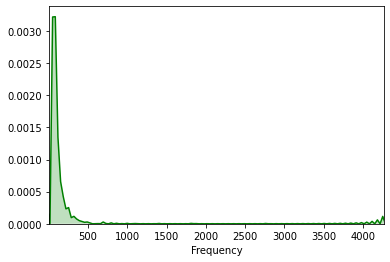

In [ ]:
plt.xlim(xmin=All_UK_Users['Frequency'].min(),xmax=All_UK_Users['Frequency'].max())
sns.distplot(All_UK_Users['Frequency'], hist=False, color="g", kde_kws={"shade": True})

## **Visualizing Recency**

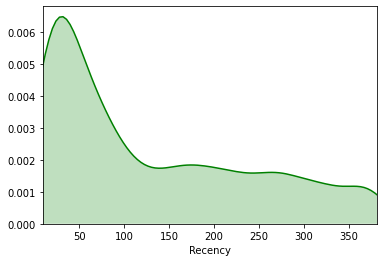

In [ ]:
plt.xlim(xmin=All_UK_Users['Recency'].min(),xmax=All_UK_Users['Recency'].max())
sns.distplot(All_UK_Users['Recency'], hist=False, color="g", kde_kws={"shade": True})


## **Visualizing Monetary**

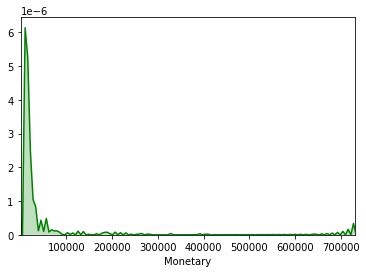

In [ ]:
plt.xlim(xmin=All_UK_Users['Monetary'].min(),xmax=All_UK_Users['Monetary'].max())
sns.distplot(All_UK_Users['Monetary'], hist=False, color="g", kde_kws={"shade": True})


In [ ]:
plt.xlim(xmin=All_UK_Users['Contribution'].min(),xmax=All_UK_Users['Contribution'].max())
sns.distplot(All_UK_Users['Contribution'], hist=False, color="g", kde_kws={"shade": True})

In [ ]:
Frequnecy_outliers=All_UK_Users[All_UK_Users['Frequency']>400]
#Monetary_outliers= All_UK_Users[All_UK_Users['Monetary']>40000]
Recency_outliers= All_UK_Users[All_UK_Users['Recency']>180]

FR_outliers=pd.merge(Frequnecy_outliers,Recency_outliers,on='UserId',how='outer')
#FM_outliers['Contribution_y'].min()


#FM_outliers=pd.merge(FM_outliers,Recency_outliers,on='UserId',how='outer')

#Frequnecy_outliers['Frequency'].min()
remove_users=pd.DataFrame(FR_outliers.iloc[:,0])

data_without_outliers=All_UK_Users[~All_UK_Users.UserId.isin(remove_users.UserId)]

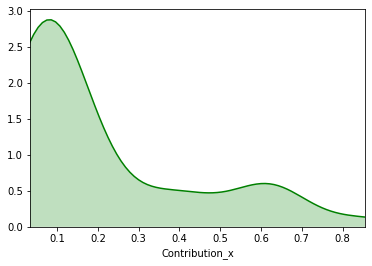

In [ ]:
#Studying outliers
plt.xlim(xmin=FR_outliers['Contribution_x'].min(),xmax=FR_outliers['Contribution_x'].max())
sns.distplot(FR_outliers['Contribution_x'], hist=False, color="g", kde_kws={"shade": True})


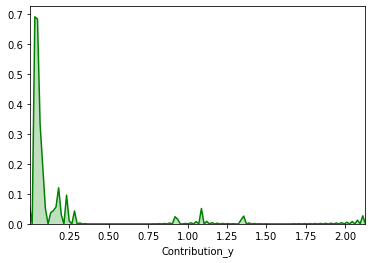

In [ ]:
#Studying outliers
plt.xlim(xmin=FR_outliers['Contribution_y'].min(),xmax=FR_outliers['Contribution_y'].max())
sns.distplot(FR_outliers['Contribution_y'], hist=False, color="g", kde_kws={"shade": True})


In [ ]:
#making df of outlier data
valid_users=[]
valid_users1=FR_outliers[FR_outliers['Contribution_x']<=0.3].UserId
valid_users2=FR_outliers[FR_outliers['Contribution_y']<=0.3].UserId
 
valid_users=pd.merge(valid_users1 ,valid_users2,on='UserId',how='outer')

outlier_data=All_UK_Users[All_UK_Users['UserId'].isin(valid_users['UserId'])]

# **Scaling of RFM**

In [ ]:

#log wokrs good....appx similar nature of data
data_without_outliers['Scaled_Recency']=data_without_outliers['Recency'].apply(lambda x: np.log(x))
data_without_outliers['Scaled_Frequency']=data_without_outliers['Frequency'].apply(lambda x: np.log(x))
data_without_outliers['Scaled_Monetary']=data_without_outliers['Monetary'].apply(lambda x: np.log(x))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

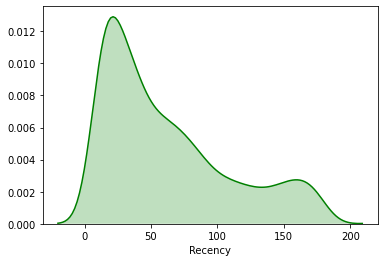

In [ ]:
sns.distplot(data_without_outliers['Recency'], hist=False, color="g", kde_kws={"shade": True})


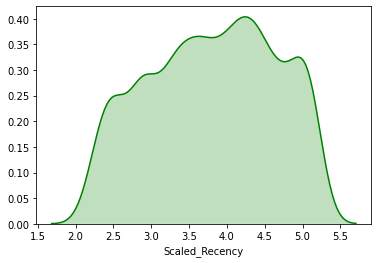

In [ ]:
sns.distplot(data_without_outliers['Scaled_Recency'], hist=False, color="g", kde_kws={"shade": True})

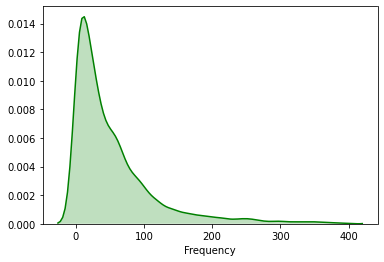

In [ ]:
sns.distplot(data_without_outliers['Frequency'], hist=False, color="g", kde_kws={"shade": True})

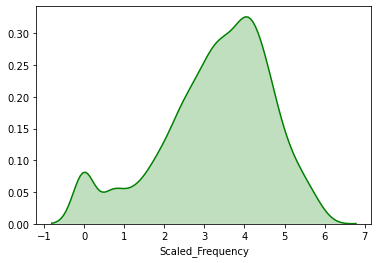

In [ ]:
sns.distplot(data_without_outliers['Scaled_Frequency'], hist=False, color="g", kde_kws={"shade": True})

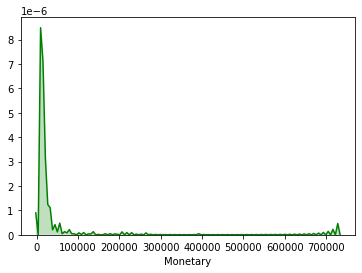

In [ ]:
sns.distplot(data_without_outliers['Monetary'], hist=False, color="g", kde_kws={"shade": True})

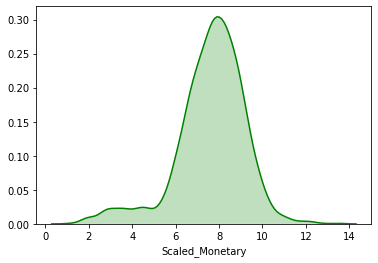

In [ ]:
sns.distplot(data_without_outliers['Scaled_Monetary'], hist=False, color="g", kde_kws={"shade": True})

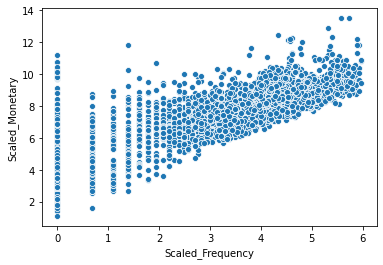

In [ ]:

#X=data_without_outliers[['Scaled_Recency','Scaled_Frequency','Scaled_Monetary']]
#fig = px.scatter_3d(X, x='Scaled_Recency', y='Scaled_Frequency', z='Scaled_Monetary')
#fig.show()

X=data_without_outliers[['Scaled_Frequency','Scaled_Monetary']]
sns.scatterplot(x=X['Scaled_Frequency'],y=X['Scaled_Monetary'])



#Applying K means algorithm  on RFM ratings 

For n_clusters = 2, silhouette score is [0.4883714710773123])
For n_clusters = 3, silhouette score is [0.4883714710773123, 0.4590369552049211])
For n_clusters = 4, silhouette score is [0.4883714710773123, 0.4590369552049211, 0.3971073640011573])
For n_clusters = 5, silhouette score is [0.4883714710773123, 0.4590369552049211, 0.3971073640011573, 0.4091468493181454])
For n_clusters = 6, silhouette score is [0.4883714710773123, 0.4590369552049211, 0.3971073640011573, 0.4091468493181454, 0.3717446765984257])
For n_clusters = 7, silhouette score is [0.4883714710773123, 0.4590369552049211, 0.3971073640011573, 0.4091468493181454, 0.3717446765984257, 0.3601435631114701])
For n_clusters = 8, silhouette score is [0.4883714710773123, 0.4590369552049211, 0.3971073640011573, 0.4091468493181454, 0.3717446765984257, 0.3601435631114701, 0.3361094333544172])
For n_clusters = 9, silhouette score is [0.4883714710773123, 0.4590369552049211, 0.3971073640011573, 0.4091468493181454, 0.3717446765984257, 0.360

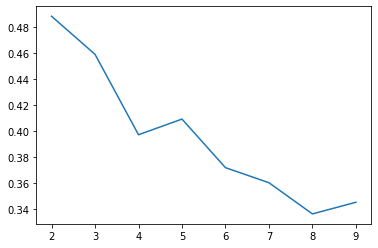

In [ ]:
wcss = []
for i in range(2, 10):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0,n_jobs=-1)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


from sklearn.metrics import silhouette_score
score=[]
for i in range(2,10):
    clusterer = KMeans(n_clusters=i)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score.append(silhouette_score(X, preds))
    print("For n_clusters = {}, silhouette score is {})".format(i, score))
plt.plot(range(2, 10), score)
plt.show()

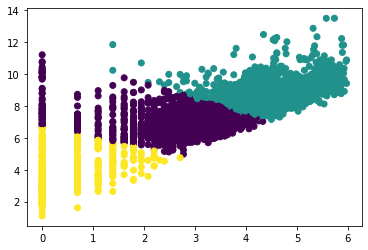

In [ ]:

#not so clear elbow to decide  number of clusters but let's allow some error in model and select 5 as number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0,n_jobs=-1)
kmeans.fit(X)

sns.scatterplot(x=X['Scaled_Frequency'],y=X['Scaled_Monetary'],hue=kmeans.labels_)
plt.figure(figsize=(10, 7))  
plt.scatter(X['Scaled_Frequency'], X['Scaled_Monetary'], c=kmeans.labels_) 

#fig = px.scatter_3d(X, x='Scaled_Recency', y='Scaled_Frequency', z='Scaled_Monetary',color=kmeans.labels_)
#fig.show()
data_without_outliers['Frequency'].min()
data_without_outliers['cluster']=kmeans.labels_

#NOTE : low recency vaule shows that customer had recently bought item(s) from the website
#Ideal values of RFM of core customers which makes most of the revenue:
#Recency :low , frequency : high , monetary:high

In [ ]:
#clustering outlier data

outlier_data[['Scaled_Recency','Scaled_Frequency','Scaled_Monetary']]=np.log(outlier_data[['Recency','Frequency','Monetary']])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



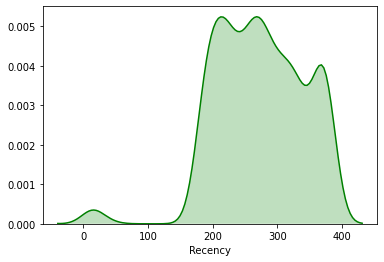

In [ ]:
sns.distplot(outlier_data['Recency'], hist=False, color="g", kde_kws={"shade": True})

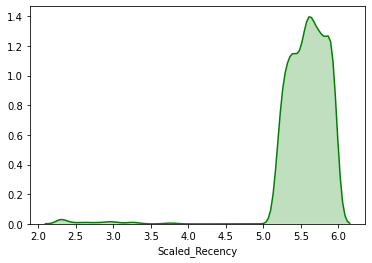

In [ ]:
sns.distplot(outlier_data['Scaled_Recency'], hist=False, color="g", kde_kws={"shade": True})

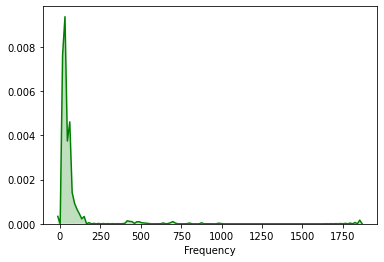

In [ ]:
sns.distplot(outlier_data['Frequency'], hist=False, color="g", kde_kws={"shade": True})

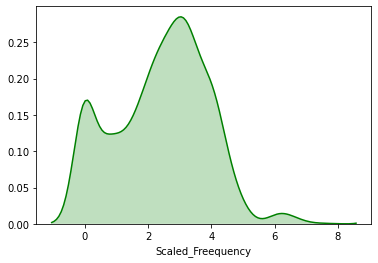

In [ ]:
sns.distplot(outlier_data['Scaled_Frequency'], hist=False, color="g", kde_kws={"shade": True})

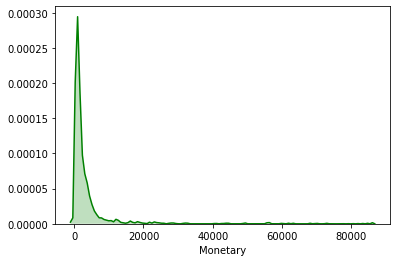

In [ ]:
sns.distplot(outlier_data['Monetary'], hist=False, color="g", kde_kws={"shade": True})

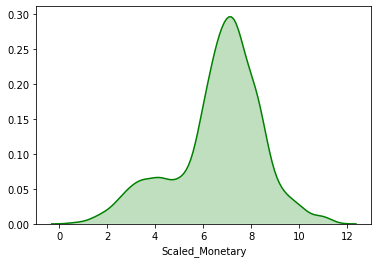

In [ ]:
sns.distplot(outlier_data['Scaled_Monetary'], hist=False, color="g", kde_kws={"shade": True})

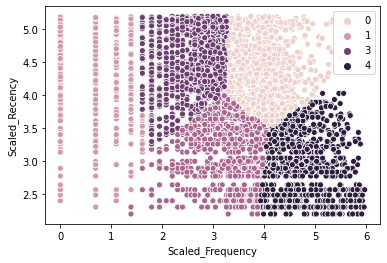

In [ ]:
X=outlier_data[['Scaled_Recency','Scaled_Frequency','Scaled_Monetary']]
fig = px.scatter_3d(X, x='Scaled_Recency', y='Scaled_Frequency', z='Scaled_Monetary')
fig.show()

X=data_without_outliers[['Scaled_Frequency','Scaled_Recency']]
sns.scatterplot(x=X['Scaled_Frequency'],y=X['Scaled_Recency'])


wcss = []
for i in range(2, 10):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0,n_jobs=-1)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



score=[]
for i in range(2,10):
    clusterer = KMeans(n_clusters=i)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score.append(silhouette_score(X, preds))
    print("For n_clusters = {}, silhouette score is {})".format(i, score))
plt.plot(range(2, 10), score)
plt.show()

fig = px.scatter_3d(X, x='Scaled_Recency', y='Scaled_Frequency', z='Scaled_Monetary',color=kmeans.labels_)
fig.show()

# Creating Dataframes according to the clusters

In [ ]:
cluster_0 = All_UK_Users[All_UK_Users['cluster']==0]
cluster_1 = All_UK_Users[All_UK_Users['cluster']==1]
cluster_2 = All_UK_Users[All_UK_Users['cluster']==2]
cluster_3 = All_UK_Users[All_UK_Users['cluster']==3]
cluster_4 = All_UK_Users[All_UK_Users['cluster']==4]


,UserId,Recency,Frequency,Monetary,cluster
23,269661,-1.028073,2.869699,0.003949,4
39,270207,-0.833010,2.182906,-0.005171,4
75,271341,-1.036939,3.861734,0.056963,4
112,272391,-1.036939,2.154289,0.055720,4
132,273021,-1.028073,1.715504,0.036454,4
...,...,...,...,...,...
3815,380289,-1.054672,3.375256,0.034810,4
3826,380562,-0.992607,1.515190,-0.014616,4
3901,382683,-1.054672,1.515190,0.012989,4
3947,383943,-1.036939,1.763198,-0.017225,4


[1, 2, 4, 4, 5, 6]